<a href="https://colab.research.google.com/github/enzo-augusto/Agulha-de-Buffon-Paralelo/blob/main/EP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primeira versão do código, gera apenas um valor de PI:

In [ ]:
%%writefile BuffonMPI.cpp
//Versão 1.0 do código. Gera apenas um valor de PI.
#define _USE_MATH_DEFINES
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <math.h>
#include "mpi.h"
#include <unistd.h>

// gera floats aleatorios dentro de um intervalo dado
double gera_random (double inicio_intervalo, double tamanho_intervalo)
{
    return ((double) rand()/(double) RAND_MAX)* tamanho_intervalo + inicio_intervalo;
}

int main(int argc, char **argv)
{

    //inicializando as variáveis específicas do MPI
    int MyRank, Numprocs, tag, totalLancamentos;

    // Inicializando o ambiente de programação em paralelo
    MPI_Init(&argc, &argv);
    MPI_Comm_size(MPI_COMM_WORLD, &Numprocs);
    MPI_Comm_rank(MPI_COMM_WORLD, &MyRank);

    //Inicializando a srand de forma a gerar números diferentes para cada processo
    srand(getpid()*time(NULL)*MyRank);

    //Inicializando todas as variáveis a serem usadas
    int lancamentos = 100000;
    double pi, erroReal, erroExp;
    MPI_Status status;
    tag = 1;
    int acertos = 0;
    int soma;

    //Loop que simula os lançamentos de agulhas e conta a quantidade de acertos
    for(int i = 0; i <= lancamentos; i++)
    {
        double centro = gera_random(0, 1 );
        double angulo = gera_random(0, M_PI_2);

        if( cos(angulo)/2 >= centro)
        {
        acertos++;
        }

    }

    //Soma todos os acertos e envia o resultado para o rank 0;
    MPI_Reduce((void*)& acertos, (void*) &soma, 1, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);

    MPI_Finalize();

    //Rank zero calcula o valor de pi utilizando o número total de lançamentos e de acertos
    if(MyRank == 0)
    {
        totalLancamentos = Numprocs*lancamentos;
        pi = (double) totalLancamentos/(double) soma;
        erroReal = fabs(M_PI - pi);
        erroExp = pi/sqrt((double) totalLancamentos);
        printf("%d \n", totalLancamentos);
        printf("%d \n", soma);
        printf("Apos %d lancamentos, encontramos o valor %lf para pi, com erro experimental %lf e erro real %lf \n", totalLancamentos, pi, erroExp,  erroReal);
    }

    return 0;
}

Overwriting BuffonMPI.cpp


In [ ]:
!mpic++ BuffonMPI.cpp -o BuffonMPI
!mpiexec -n 2 --allow-run-as-root --oversubscribe ./BuffonMPI

200000 
63661 
Apos 200000 lancamentos, encontramos o valor 3.141641 para pi, com erro experimental 0.007025 e erro real 0.000048 


Segunda versão do código. Gera 100 valores de PI, cada valor gerado com mais lançamentos que o anterior, essa versão foi a utilizada para a análise com a Lei de Amdahl

In [ ]:
%%writefile BuffonMPI2.cpp

/*Versao 2.0 do codigo. Gera diversos valores de pi com diferentes numeros de lancamentos,
calcula e plota o erro experimental, o erro real e o número de lancamentos para cada valor de pi */

#define _USE_MATH_DEFINES
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <math.h>
#include <unistd.h>
#include "mpi.h"

#define LANCAMENTOS_MAX 10000000
#define LANCAMENTOS_INTER 100000

// gera floats aleatorios dentro de um intervalo dado
double gera_random (double inicio_intervalo, double tamanho_intervalo)
{
    return ((double) rand()/(double) RAND_MAX)* tamanho_intervalo + inicio_intervalo;
}

int main(int argc, char **argv)
{

    //inicializando as variáveis específicas da versão MPI
    int MyRank, Numprocs, tag, totalLancamentos;

    // Inicializando o ambiente de programação em paralelo
    MPI_Init(&argc, &argv);
    MPI_Comm_size(MPI_COMM_WORLD, &Numprocs);
    MPI_Comm_rank(MPI_COMM_WORLD, &MyRank);

    //Inicializando a srand de forma a gerar números diferentes para cada processo
    srand(time(NULL)*getpid());

    //Inicializando todas as variáveis a serem usadas
    int lancamentos, soma;
    int acertos = 0;
    int lancTotais = LANCAMENTOS_MAX/Numprocs;
    int lancIntervalo = LANCAMENTOS_INTER/Numprocs;
    double pi, erroReal, erroExp, diferenca, angulo, centro;

    //O for interno é identico ao utilizado na versao 1.0 para gerar um valor de pi.
    //O for externo varia o numero de lancamentos, gerando 100 dados.
    for(lancamentos = lancIntervalo; lancamentos <= lancTotais; lancamentos += lancIntervalo)
    {
        acertos = 0;

        //Loop que simula os lançamentos de agulhas e conta a quantidade de acertos
        for(int i = 0; i <= lancamentos; i++)
        {
            centro = gera_random(0, 1 );
            angulo = gera_random(0, M_PI_2);

            if( cos(angulo)/2 >= centro)
            {
                acertos++;
            }

        }

        //Soma todos os acertos e envia o resultado para o rank 0;
        MPI_Reduce((void*)& acertos, (void*) &soma, 1, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);

        //Rank zero calcula o valor de pi utilizando o número total de lançamentos e de acertos
        if(MyRank == 0)
        {
            totalLancamentos = Numprocs*lancamentos;
            pi = (double) totalLancamentos/(double) soma;
            erroReal = fabs(M_PI - pi);
            erroExp = pi/sqrt((double) totalLancamentos);
            diferenca = fabs(erroReal - erroExp);

            printf(" %lf \n", pi);
        }

    }

    //Rank zero printa o tempo que o código demorou para rodar
    if(MyRank == 0)
    {
        printf("%lf \n",(double)clock()/CLOCKS_PER_SEC);
    }

    MPI_Finalize();

    return 0;
}

Overwriting BuffonMPI2.cpp


In [ ]:
!mpic++ BuffonMPI2.cpp -o BuffonMPI2
!mpiexec -n 2 --allow-run-as-root --oversubscribe ./BuffonMPI2

# Lei de Amdahl

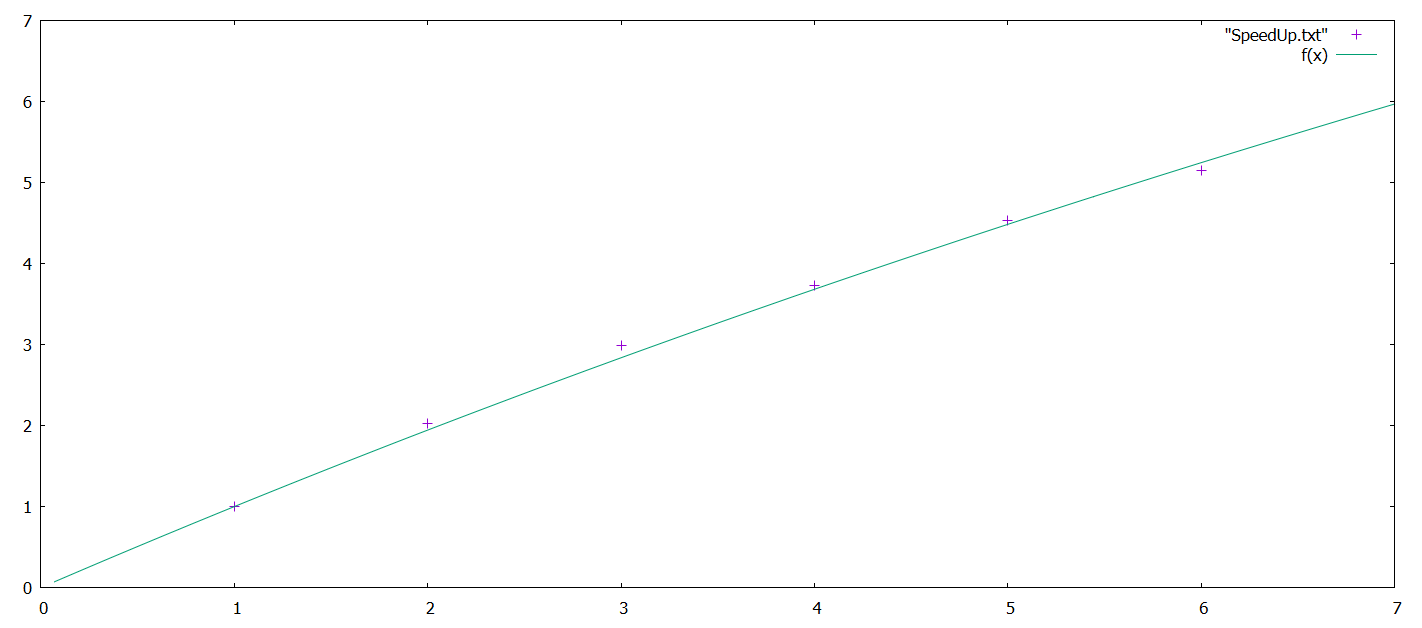

O gráfico acima foi gerado no GNUplot utilizando o método dos mínimos quadrados, encontrando um valor de 0.97119 para p. Esse valor alto é esperado, vendo que o grosso do nosso código, o loop interno que gera a quantidade de acertos, é paralelizada. Na parte serial apenas calculamos o valor de pi com as grandezas que já temos.
Esse gráfico foi gerado com seis pontos, já que essa é a quantidade de cores do meu processador.